# Task 5.2DHD

In [15]:
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.decomposition import PCA
import pandas as pd
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline
from pandas import DataFrame
from sklearn.compose import ColumnTransformer
from sklearn.metrics import zero_one_loss, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

def print_score(classifier_name: str, y_test_data, y_pred_data):
    print(f"\n{classifier_name}\n")
    print(f"Zero One Loss: {zero_one_loss(y_test_data, y_pred_data):.4f}")
    print(f"Accuracy: {accuracy_score(y_test_data, y_pred_data):.2f}")
    print("\nClassification Report:\n", classification_report(y_test_data, y_pred_data))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test_data, y_pred_data))

df: DataFrame = pd.read_csv('data/Week_5_NSL-KDD-Dataset/kdd_merged.csv')
nominal_columns: list[str] = ['protocol_type', 'service', 'flag', 'attack_type', 'attack_category']
binary_columns: list[str] = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']
numeric_columns: list[str] = ['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot',
                              'num_failed_logins', 'num_compromised', 'num_root', 'num_file_creations', 'num_shells',
                              'num_access_files', 'num_outbound_cmds', 'count', 'srv_count', 'serror_rate',
                              'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
                              'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
                              'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
                              'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
                              'dst_host_srv_rerror_rate', 'success_pred']

# Data preprocessing (Based on EDA)
df.drop('num_outbound_cmds', inplace=True, axis=1)
numeric_columns.remove('num_outbound_cmds')
df['su_attempted'] = df['su_attempted'].replace({2: 0})

# Prepare features and target
X = df.drop(['attack_category', 'attack_type'], axis=1)
nominal_columns.remove('attack_category')
nominal_columns.remove('attack_type')
y = df['attack_category']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode target variable
label_encoder: LabelEncoder = LabelEncoder().fit(y_train)
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), nominal_columns)
    ],
    remainder='passthrough'
)

# feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(nominal_columns).tolist() + numeric_columns + binary_columns

# Main modeling pipeline
pipeline = make_pipeline(
    preprocessor,
    PCA(n_components=0.95),
    ADASYN(random_state=42),
    EditedNearestNeighbours(),
    KNeighborsClassifier(5)
)

# Train and evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print_score("KNN-Pipeline", y_test, y_pred)


C:\Users\shoun\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



KNN-Pipeline

Zero One Loss: 0.0065
Accuracy: 0.99

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     15450
           1       1.00      1.00      1.00     10723
           2       0.98      0.99      0.99      2750
           3       0.92      0.96      0.94       724
           4       0.58      0.81      0.68        57

    accuracy                           0.99     29704
   macro avg       0.90      0.95      0.92     29704
weighted avg       0.99      0.99      0.99     29704


Confusion Matrix:
 [[15321    24    43    45    17]
 [    5 10713     4     1     0]
 [    1     3  2736     5     5]
 [    1     3    13   696    11]
 [    0     0     2     9    46]]


C:\Users\shoun\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


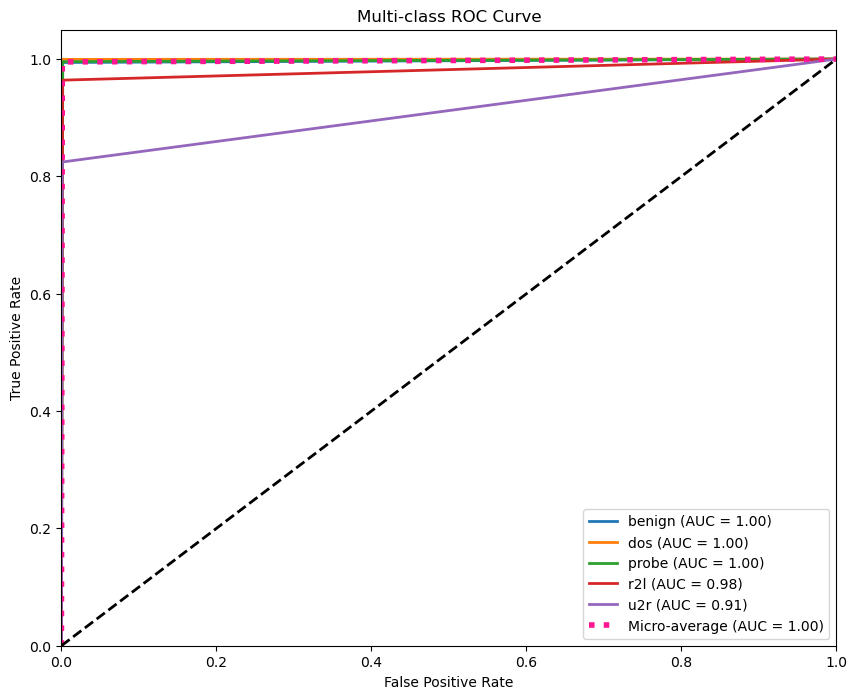

In [16]:
# Add these imports at the top
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Add this code after your print_score() call
# Get predicted probabilities
y_proba = pipeline.predict_proba(X_test)

# Binarize the true labels
classes = label_encoder.classes_
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (AUC = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average (AUC = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()

# SVM Implementation